In [1]:
import numpy as np
import matplotlib.pyplot as plt
from ICMDP import *
from scipy.optimize import minimize
import os
import pickle
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import shutil
from Ellipsoid import *

#LINUX
# import sys
# valuesindex = int(sys.argv[1])
# testi = int(sys.argv[2])
# testf = int(sys.argv[3])

def save_obj(obj, name):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

C:\Users\Philip\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\parallel.py:13: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  "You should import from ipyparallel instead.", ShimWarning)
C:\Users\Philip\AppData\Local\Continuum\anaconda3\lib\site-packages\qinfer\parallel.py:52: UserWarning: Could not import IPython parallel. Parallelization support will be disabled.
  "Could not import IPython parallel. "


In [2]:
def do_action(state,action, min_speed, max_speed, min_x, max_x, step_size):
    speed = state.speed
    my_x = state.x
    
    # move left:
    if action == 1:
        if my_x - step_size >= min_x:
            my_x = my_x - step_size
        else:
            my_x = min_x
    
    # move right:
    elif action == 2:
        if my_x + step_size <= max_x:
            my_x = my_x + step_size
        else:
            my_x = max_x
    
    # increase speed:
    elif action == 3:
        if speed < max_speed:
            speed = speed + 1
    
    # decrease speed:
    elif action == 4:
        if speed > min_speed:
            speed = speed - 1

    return [speed,my_x]

# find next state function - finds the next possible states for a given state and action:


def find_next_state(state,action,states_inv):
    [new_speed, new_x] = do_action(state,action,speeds_num[0],speeds_num[-1], left_bound,right_bound,5)

    # check if this is the first state:
    if (states_inv[','.join(str(elem) for elem in (state.as_list()))] == 0):

        # for first state - special control for speed, to choose the speed for the rest of the game:
        state_vec = []
        for x in other_car_x:
            if action == 0:
                init_speed = state.speed
            elif action == 1:
                init_speed = state.speed - 1
            elif action == 2:
                init_speed = state.speed + 1

            # insert a car in a random position:
            new_state = states_inv[ ','.join(str(elem) for elem in [init_speed,state.x,x,10])]
            state_vec.append(new_state)
        return state_vec

    # check if need to insert a new car in a random place and remove the old one:
    elif (state.other_car[1] + displace[state.speed] >= height - 10 + my_car_size[0]):
        state_vec = []
        for x in other_car_x:
            new_state = states_inv[ ','.join(str(elem) for elem in [new_speed,new_x,x,10])]
            state_vec.append(new_state)
        return state_vec

    # no new car needed - deterministic next state:
    else:
        new_state = states_inv[','.join(str(elem) for elem in [new_speed, new_x ,state.other_car[0],state.other_car[1] + displace[state.speed]])]
        return new_state


# features:
# 1. speed
# 2. collisions
# 3. off-road

# actions:
# 0 - do nothing
# 1 -  move left
# 2 - move right

# parameters:
# right-left step size:
step_size = 5

# boundaries of the frame
left_bound = 120
right_bound = 200
height = 180
width = 300
bottom_bound = height

# boundaries of the road:
road_left_bound = left_bound + 20
road_right_bound = right_bound - 20

# car size, width is half of the width in the format "[length,width]":
my_car_size = [40, 10]

# the y position of the player's car (stays fixed during the game):
my_y = height - 10 - my_car_size[0]

# initiate the speed feature values, displace for each speed and numbering:
displace = [20, 40, 80]
speeds_num = [0,1,2]
speed_feature_vals = [0.5,0.75,1]

# calculate the different possible x positions of the player's car:
my_x = []
for x in range(left_bound,right_bound + step_size,step_size):
    my_x.append(x)

# the lanes locations:
lanes = [140,160,180] # the x coordinates of the lanes

# build other_car:
other_car_length = 40
other_car_width = 10
other_car_x = lanes # to lower complexity
other_car_y = [] # the legal y coordinates of the other cars
for i in range(10):
    other_car_y.append(20*i + 10)

other_car = [] # format: [x coordinate, y coordinate]
for x in other_car_x:
    for y in other_car_y:
        other_car.append([x,y])

# build actions:
# 0 - do nothing
# 1 - move left
# 2 - move right
actions = [0,1,2]

# initiate states array and state to index (states_inv) dictionary:
states = []
states_inv = {}

# initiate features:
F = Features(dim_features=3)

# add first  state:
states.append(State(1,160,[-1,-1]))
states_inv[','.join(str(elem) for elem in (states[0].as_list()))] = 0
F.add_feature(feature=[0.75,0.5,0.5])

# build the whole state - feature mapping:
for speed in speeds_num:
    for x in my_x:
        for other_x in other_car_x:
            for other_y in other_car_y:
                states.append(State(speed,x,[other_x,other_y]))
                states_inv[','.join(str(elem) for elem in (states[len(states)-1].as_list()))] = len(states) - 1

                # add speed feature value:
                speed_val = speed_feature_vals[speed]
                
                # check collision:
                if (other_y > my_y) and (other_y - other_car_length < my_y + my_car_size[0]) and (other_x + other_car_width > x - my_car_size[1]) and (other_x - other_car_width < x + my_car_size[1]):
                    collision_val = 0
                else:
                    collision_val = 0.5

                # check off-road:
                if (x < road_left_bound) or (x  > road_right_bound):
                    off_road_val = 0
                else:
                    off_road_val = 0.5

                F.add_feature(feature=[speed_val,collision_val,off_road_val])


# setup transitions:
THETA = Transitions(num_states=len(states), num_actions=len(actions))
curr_state = 0
for state in states:
    for action in actions:

        # find next state:
        new_state = find_next_state(state,action,states_inv)

        # if there is more than 1 possible next state, calculate uniform distribution between the possibilities:
        if isinstance(new_state, list):
            num_states = len(new_state)
            trans = 1.0/num_states
            for i in range(num_states):
                THETA.set_trans(curr_state,action,new_state[i],trans)
        
        # deterministic next state:
        else:
            THETA.set_trans(curr_state,action,new_state,1)

    curr_state = curr_state + 1

# initiate an ICMDP object:
mdp = ICMDP()

# set the calculated features and transitions:
mdp.set_F(F)
mdp.set_THETA(THETA)

100%|█████████████████████████████████████████████████████████████████████████████| 1531/1531 [00:02<00:00, 695.24it/s]


In [7]:
#HYPER PARAMS
iters = 200
real_W = np.load("realW.npy")
# real_W = real_W/(abs(real_W).max())
epsilon = 1e-3
#LINUX
repeats = 10
# repeats = testf-testi
tol = 1e-4
RUN_TEST = True

In [8]:
%%time
d={}

test_expert_value = 0
testset = np.load("big_train_test_sets/test_set.npy")
testset = testset[:80]
# Evaluate expert on test set
if RUN_TEST:
    test_expert_value = []
    for c in testset:
        mdp.set_C(c)
        mdp.set_W(real_W)
        features_expert = mdp.solve_CMDP(gamma=0.9, tol=tol, flag='init')
        value_expert = ((1-0.9)/real_W.shape[1]) * c @ real_W @ features_expert.M
        test_expert_value.append(value_expert)
    test_expert_value = np.asarray(test_expert_value).mean()
    d["test_value"] = test_expert_value

#LINUX
for trainset in range(repeats):
# for trainset in range(testi,testf):
    if trainset>0 and trainset%5==1:
        #LINUX
        save_obj(d, "values0")
#         save_obj(d, "values"+str(valuesindex))

    Conts = np.load("big_train_test_sets/train_set_"+str(trainset)+".npy")
    Conts = Conts[:iters]

    expert_values = np.zeros(len(Conts))
    agent_values = np.zeros(len(Conts))
    cumm_regret = np.zeros(len(Conts))
    W_L2_dist = np.zeros(len(Conts))
    W_Li_dist = np.zeros(len(Conts))
    W_angular_dist = np.zeros(len(Conts))
    contexts_seen = np.zeros(len(Conts))
    context_count = 0
    ellipsoid_volume = np.zeros(len(Conts))
#     Qs = []
#     cs = []
#     Ws = []
#     e_feat = []
#     a_feat = []
    ERR = False

    E = Ellipsoid(real_W.size)

    max_updates = 2*real_W.size*(real_W.size + 1)*np.log(4*np.sqrt(real_W.size)/epsilon)
#     print("Max updates possible:",max_updates)
    min_ellipsoid_vol = (epsilon/2)**real_W.size
#     print("lower bound on ellipsoid volume:",min_ellipsoid_vol)

    for t in range(iters):
        #LINUX
        print("test ",trainset," timestep ",t)
#         print("Run ",valuesindex," test ",trainset, " of ", str(testi), "->" , str(testf),"timestep ",t)

        # Agent and teacher play
        ct = Conts[t]
        mdp.set_C(ct)
        Wt = E.getc().reshape(real_W.shape)
        mdp.set_W(real_W)
        features_expert = mdp.solve_CMDP(gamma=0.9, tol=tol, flag='init')
        mdp.set_W(Wt)
        features_agent = mdp.solve_CMDP(gamma=0.9, tol=tol, flag='init')
        value_expert = ((1-0.9)/real_W.shape[1]) * ct @ real_W @ features_expert.M
        value_agent = ((1-0.9)/real_W.shape[1]) * ct @ real_W @ features_agent.M

        # Sanity checks
        if t > 0 and ellipsoid_volume[t] > ellipsoid_volume[t-1]:
            print("ERR: Volume increased. t=",t," trainset=",trainset)
            ERR = True
        if context_count > max_updates:
            print("ERR: Went over max updates!. t=",t," trainset=",trainset)
            ERR = True
        if E.volume() < min_ellipsoid_vol:
            print("ERR: Ellipsoid too small!. t=",t," trainset=",trainset)
            ERR = True
        if not E.inside(real_W.reshape(real_W.size)):
            print("ERR: Real solution no longer in ellipsoid. t=",t," trainset=",trainset)
            ERR = True
        
        # Record results
        expert_values[t] = value_expert
        agent_values[t] = value_agent
        W_L2_dist[t] = np.linalg.norm(Wt-real_W)/np.linalg.norm(real_W)
        W_Li_dist[t] = np.linalg.norm((Wt-real_W).reshape(real_W.size),np.inf)/np.linalg.norm(real_W.reshape(real_W.size),np.inf)
        W_angular_dist[t] = np.arccos((Wt.reshape(real_W.size) @ real_W.reshape(real_W.size))/(np.linalg.norm(Wt)*np.linalg.norm(real_W)+1e-9))/np.pi
        contexts_seen[t] = context_count
        ellipsoid_volume[t] = E.volume()
        if t>0:
            cumm_regret[t] = cumm_regret[t-1] + value_expert - value_agent
        elif t==0:
            cumm_regret[t] = value_expert - value_agent
#         Qs.append(E.getQ())
#         cs.append(E.getc())
#         Ws.append(Wt)
#         e_feat.append(features_expert)
#         a_feat.append(features_agent)
        
        #Calculate values on test set
        if (RUN_TEST and t>0 and contexts_seen[t] % 5 == 0 and contexts_seen[t] != contexts_seen[t-1]) or (RUN_TEST and t==0):
            test_agent_value = []
            for c in testset:
                mdp.set_C(c)
                mdp.set_W(Wt)
                features_agent = mdp.solve_CMDP(gamma=0.9, tol=tol, flag='init')
                value_agent = ((1-0.9)/real_W.shape[1]) * c @ real_W @ features_agent.M
                test_agent_value.append(value_agent)
            test_agent_value = np.asarray(test_agent_value).mean()
            d[trainset,"test_value",contexts_seen[t]] = test_agent_value
            d[trainset,"test_L2_dist",contexts_seen[t]] = W_L2_dist[t]
            d[trainset,"test_Li_dist",contexts_seen[t]] = W_Li_dist[t]
            d[trainset,"test_ang_dist",contexts_seen[t]] = W_angular_dist[t]

        # If agent is more than epsilon suboptimal, update ellipsoid
        if value_expert - value_agent > epsilon:
            E.update(np.outer(ct,features_expert.M-features_agent.M).reshape(real_W.size))
            context_count += 1
    
    d[trainset,"expert_values"] = expert_values
    d[trainset,"agent_values"] = agent_values
    d[trainset,"W_L2_dist"] = W_L2_dist
    d[trainset,"W_Li_dist"] = W_Li_dist
    d[trainset,"W_angular_dist"] = W_angular_dist
    d[trainset,"contexts_seen"] = contexts_seen
    d[trainset,"cumm_regret"] = cumm_regret
#     d[trainset,"ellipsoid_volume"] = ellipsoid_volume
#     d[trainset,"Qs"] = Qs
#     d[trainset,"cs"] = cs
#     d[trainset,"Ws"] = Ws
#     d[trainset,"e_feat"] = e_feat
#     d[trainset,"a_feat"] = a_feat
#     d[trainset,"ERR"] = ERR

#     if(ERR):
#         print("Error during run ")

#LINUX
save_obj(d, "values0")
# save_obj(d, "values"+str(valuesindex))

test  0  timestep  0
test  0  timestep  1
test  0  timestep  2
test  0  timestep  3
test  0  timestep  4
test  0  timestep  5
test  0  timestep  6
test  0  timestep  7
test  0  timestep  8
test  0  timestep  9
test  0  timestep  10
test  0  timestep  11
test  0  timestep  12
test  0  timestep  13
test  0  timestep  14
test  0  timestep  15
test  0  timestep  16
test  0  timestep  17
test  0  timestep  18
test  0  timestep  19
test  0  timestep  20
test  0  timestep  21
test  0  timestep  22
test  0  timestep  23
test  0  timestep  24
test  0  timestep  25
test  0  timestep  26
test  0  timestep  27
test  0  timestep  28
test  0  timestep  29
test  0  timestep  30
test  0  timestep  31
test  0  timestep  32
test  0  timestep  33
test  0  timestep  34
test  0  timestep  35
test  0  timestep  36
test  0  timestep  37
test  0  timestep  38
test  0  timestep  39
test  0  timestep  40
test  0  timestep  41
test  0  timestep  42
test  0  timestep  43
test  0  timestep  44
test  0  timestep  4

test  1  timestep  165
test  1  timestep  166
test  1  timestep  167
test  1  timestep  168
test  1  timestep  169
test  1  timestep  170
test  1  timestep  171
test  1  timestep  172
test  1  timestep  173
test  1  timestep  174
test  1  timestep  175
test  1  timestep  176
test  1  timestep  177
test  1  timestep  178
test  1  timestep  179
test  1  timestep  180
test  1  timestep  181
test  1  timestep  182
test  1  timestep  183
test  1  timestep  184
test  1  timestep  185
test  1  timestep  186
test  1  timestep  187
test  1  timestep  188
test  1  timestep  189
test  1  timestep  190
test  1  timestep  191
test  1  timestep  192
test  1  timestep  193
test  1  timestep  194
test  1  timestep  195
test  1  timestep  196
test  1  timestep  197
test  1  timestep  198
test  1  timestep  199
test  2  timestep  0
test  2  timestep  1
test  2  timestep  2
test  2  timestep  3
test  2  timestep  4
test  2  timestep  5
test  2  timestep  6
test  2  timestep  7
test  2  timestep  8
test  

test  3  timestep  130
test  3  timestep  131
test  3  timestep  132
test  3  timestep  133
test  3  timestep  134
test  3  timestep  135
test  3  timestep  136
test  3  timestep  137
test  3  timestep  138
test  3  timestep  139
test  3  timestep  140
test  3  timestep  141
test  3  timestep  142
test  3  timestep  143
test  3  timestep  144
test  3  timestep  145
test  3  timestep  146
test  3  timestep  147
test  3  timestep  148
test  3  timestep  149
test  3  timestep  150
test  3  timestep  151
test  3  timestep  152
test  3  timestep  153
test  3  timestep  154
test  3  timestep  155
test  3  timestep  156
test  3  timestep  157
test  3  timestep  158
test  3  timestep  159
test  3  timestep  160
test  3  timestep  161
test  3  timestep  162
test  3  timestep  163
test  3  timestep  164
test  3  timestep  165
test  3  timestep  166
test  3  timestep  167
test  3  timestep  168
test  3  timestep  169
test  3  timestep  170
test  3  timestep  171
test  3  timestep  172
test  3  ti

C:\Users\Philip\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:89: ComplexWarning: Casting complex values to real discards the imaginary part


test  4  timestep  3
test  4  timestep  4
test  4  timestep  5
test  4  timestep  6
test  4  timestep  7
test  4  timestep  8
test  4  timestep  9
test  4  timestep  10
test  4  timestep  11
test  4  timestep  12
test  4  timestep  13
test  4  timestep  14
test  4  timestep  15
test  4  timestep  16
test  4  timestep  17
test  4  timestep  18
test  4  timestep  19
test  4  timestep  20
test  4  timestep  21
test  4  timestep  22
test  4  timestep  23
test  4  timestep  24
test  4  timestep  25
test  4  timestep  26
test  4  timestep  27
test  4  timestep  28
test  4  timestep  29
test  4  timestep  30
test  4  timestep  31
test  4  timestep  32
test  4  timestep  33
test  4  timestep  34
test  4  timestep  35
test  4  timestep  36
test  4  timestep  37
test  4  timestep  38
test  4  timestep  39
test  4  timestep  40
test  4  timestep  41
test  4  timestep  42
test  4  timestep  43
test  4  timestep  44
test  4  timestep  45
test  4  timestep  46
test  4  timestep  47
test  4  timestep

In [9]:
def make_graphs():
    # Calc averages
    repeats = 10
    iters = 0
    dlist = []
    for i in range(repeats):
        try:
            dlist.append(load_obj("values"+str(i)))
            if iters == 0:
                iters = len(dlist[0][0,"expert_values"])
        except:
            pass

    expert_values =    np.zeros((repeats,iters))
    agent_values =     np.zeros((repeats,iters))
    cumm_regret =      np.zeros((repeats,iters))
    W_L2_dist =        np.zeros((repeats,iters))
    W_Li_dist =        np.zeros((repeats,iters))
    W_angular_dist =   np.zeros((repeats,iters))
    contexts_seen =    np.zeros((repeats,iters))
    contexts_seen_min = np.inf
    for trainset in range(repeats):
        for d in dlist:
            if (trainset,"expert_values") in d:
                expert_values[trainset] =    d[trainset,"expert_values"]
                agent_values[trainset] =     d[trainset,"agent_values"]
                cumm_regret[trainset] =      d[trainset,"cumm_regret"]
                W_L2_dist[trainset] =        d[trainset,"W_L2_dist"]
                W_Li_dist[trainset] =        d[trainset,"W_Li_dist"]
                W_angular_dist[trainset] =   d[trainset,"W_angular_dist"]
                contexts_seen[trainset] =    d[trainset,"contexts_seen"]
                contexts_seen_min = min(contexts_seen_min, contexts_seen[trainset][-1])

    print("all runs had at least ",int(contexts_seen_min)," contexts")
    contexts_seen_min -= contexts_seen_min%5
    contexts_seen_min = int(contexts_seen_min)+5
    test_expert_value= np.zeros((repeats,int(contexts_seen_min/5)))
    test_agent_value = np.zeros((repeats,int(contexts_seen_min/5)))
    test_W_L2_dist   = np.zeros((repeats,int(contexts_seen_min/5)))
    test_W_Li_dist   = np.zeros((repeats,int(contexts_seen_min/5)))
    test_W_angular_dist = np.zeros((repeats,int(contexts_seen_min/5)))
    TESTS = False
    for trainset in range(repeats):
        for d in dlist:
                if (trainset,"test_value",5) in d:
                    TESTS = True
                    for contexts in range(0,contexts_seen_min,5):
                        test_expert_value[trainset][int(contexts/5)] = d["test_value"]
                        test_agent_value[trainset][int(contexts/5)] = d[trainset,"test_value",contexts]
                        test_W_L2_dist[trainset][int(contexts/5)] = d[trainset,"test_L2_dist",contexts]
                        test_W_Li_dist[trainset][int(contexts/5)] = d[trainset,"test_Li_dist",contexts]
                        test_W_angular_dist[trainset][int(contexts/5)] = d[trainset,"test_ang_dist",contexts]

    expert_values = expert_values[~np.all(expert_values == 0, axis=1)]
    agent_values = agent_values[~np.all(agent_values == 0, axis=1)]
    cumm_regret = cumm_regret[~np.all(cumm_regret == 0, axis=1)]
    W_Li_dist = W_Li_dist[~np.all(W_Li_dist == 0, axis=1)]
    W_L2_dist = W_L2_dist[~np.all(W_L2_dist == 0, axis=1)]
    W_angular_dist = W_angular_dist[~np.all(W_angular_dist == 0, axis=1)]
    contexts_seen = contexts_seen[~np.all(contexts_seen == 0, axis=1)]
    test_expert_value = test_expert_value[~np.all(test_expert_value == 0, axis=1)]
    test_agent_value = test_agent_value[~np.all(test_agent_value == 0, axis=1)]
    test_W_L2_dist = test_W_L2_dist[~np.all(test_W_L2_dist == 0, axis=1)]
    test_W_Li_dist = test_W_Li_dist[~np.all(test_W_Li_dist == 0, axis=1)]
    test_W_angular_dist = test_W_angular_dist[~np.all(test_W_angular_dist == 0, axis=1)]
    print("Number of runs used in graph:",len(expert_values))
    print("Timesteps in each run:",len(expert_values[0]))

    expert_values_std =     expert_values.std(axis=0)
    agent_values_std =      agent_values.std(axis=0)
    expert_values_mean =    expert_values.mean(axis=0)
    agent_values_mean =     agent_values.mean(axis=0)
    cumm_regret_mean =      cumm_regret.mean(axis=0)
    cumm_regret_std =       cumm_regret.std(axis=0)
    W_L2_dist_std =           W_L2_dist.std(axis=0)
    W_Li_dist_std =           W_Li_dist.std(axis=0)
    W_L2_dist_mean =           W_L2_dist.mean(axis=0)
    W_Li_dist_mean =           W_Li_dist.mean(axis=0)
    W_angular_dist_std =   W_angular_dist.std(axis=0)
    W_angular_dist_mean =   W_angular_dist.mean(axis=0)
    contexts_seen_std =     contexts_seen.std(axis=0)
    contexts_seen_mean =    contexts_seen.mean(axis=0)

    if TESTS:
        # Value graph (contexts)
        test_expert_value_mean = test_expert_value.mean(axis=0)
        test_expert_value_std = test_expert_value.std(axis=0)
        test_agent_value_mean = test_agent_value.mean(axis=0)
        test_agent_value_std = test_agent_value.std(axis=0)
        fig = plt.figure(figsize=(8,8))
        p = fig.add_subplot(111)

        p.plot(list(range(0,contexts_seen_min,5)), test_expert_value_mean, label="expert value", color='b')
        p.plot(list(range(0,contexts_seen_min,5)), test_agent_value_mean, label="agent value", color='r')

        p.fill_between(list(range(0,contexts_seen_min,5)), test_expert_value_mean - test_expert_value_std, test_expert_value_mean + test_expert_value_std, color='b', alpha=0.1)
        p.fill_between(list(range(0,contexts_seen_min,5)), test_agent_value_mean - test_agent_value_std, test_agent_value_mean + test_agent_value_std, color='r', alpha=0.1)

        p.set_xlabel("Contexts seen")
        p.set_ylabel("Value")
        p.tick_params('y', colors='r')

        plt.title("Test value(contexts seen)")
        p.legend(loc=8)
        plt.show()
        
        # Distance graph (contexts)
        test_W_L2_dist_mean = test_W_L2_dist.mean(axis=0)
        test_W_L2_dist_std = test_W_L2_dist.std(axis=0)
        test_W_Li_dist_mean = test_W_Li_dist.mean(axis=0)
        test_W_Li_dist_std = test_W_Li_dist.std(axis=0)
        test_W_angular_dist_mean = test_W_angular_dist.mean(axis=0)
        test_W_angular_dist_std = test_W_angular_dist.std(axis=0)
        fig = plt.figure(figsize=(8,8))
        p = fig.add_subplot(111)

        p.plot(list(range(0,contexts_seen_min,5)), test_W_L2_dist_mean, label="normalized L2 distance", color='c')
        p.plot(list(range(0,contexts_seen_min,5)), test_W_Li_dist_mean, label="normalized L infinity distance", color='b')
        p.plot(list(range(0,contexts_seen_min,5)), test_W_angular_dist_mean, label="angular distance", color='r')

        p.fill_between(list(range(0,contexts_seen_min,5)), test_W_L2_dist_mean - test_W_L2_dist_std, test_W_L2_dist_mean + test_W_L2_dist_std, color='c', alpha=0.1)
        p.fill_between(list(range(0,contexts_seen_min,5)), test_W_Li_dist_mean - test_W_Li_dist_std, test_W_Li_dist_mean + test_W_Li_dist_std, color='b', alpha=0.1)
        p.fill_between(list(range(0,contexts_seen_min,5)), test_W_angular_dist_mean - test_W_angular_dist_std, test_W_angular_dist_mean + test_W_angular_dist_std, color='r', alpha=0.1)

        p.set_xlabel("Contexts seen")
        p.set_ylabel("Distance")
        p.tick_params('y', colors='r')

        plt.title("Test Distance(contexts seen)")
        p.legend(loc=9)
        plt.show()


    # Value graph (time)
    fig = plt.figure(figsize=(8,8))
    p2 = fig.add_subplot(111)
    p = p2.twinx()

    p2.plot(list(range(iters)), contexts_seen_mean, label="Contexts seen", color='g')
    p2.fill_between(list(range(iters)), contexts_seen_mean - contexts_seen_std, contexts_seen_mean + contexts_seen_std, color='g', alpha=0.05)
    p2.set_ylabel("Contexts seen")
    p2.tick_params('y', colors='g')

    p.plot(list(range(iters)), expert_values_mean, label="expert value", color='b')
    p.plot(list(range(iters)), agent_values_mean, label="agent value", color='r')

    p.fill_between(list(range(iters)), expert_values_mean - expert_values_std, expert_values_mean + expert_values_std, color='b', alpha=0.1)
    p.fill_between(list(range(iters)), agent_values_mean - agent_values_std, agent_values_mean + agent_values_std, color='r', alpha=0.1)

    p.set_xlabel("Time")
    p.set_ylabel("Value")
    p.tick_params('y', colors='r')

    plt.title("Value(t,contexts seen)")
    p2.legend(loc=4)
    p.legend(loc=8)
    plt.show()

    # Distance graph (time)
    fig = plt.figure(figsize=(8,8))
    p2 = fig.add_subplot(111)
    p = p2.twinx()

    p2.plot(list(range(iters)), contexts_seen_mean, label="Contexts seen", color='g')
    p2.fill_between(list(range(iters)), contexts_seen_mean - contexts_seen_std, contexts_seen_mean + contexts_seen_std, color='g', alpha=0.05)
    p2.set_ylabel("Contexts seen")
    p2.tick_params('y', colors='g')

    p.plot(list(range(iters)), W_L2_dist_mean, label="normalized L2 distance", color='c')
    p.plot(list(range(iters)), W_Li_dist_mean, label="normalized Linfinity distance", color='b')
    p.plot(list(range(iters)), W_angular_dist_mean, label="angular distance", color='r')
    
    p.fill_between(list(range(iters)), W_L2_dist_mean - W_L2_dist_std, W_L2_dist_mean + W_L2_dist_std, color='c', alpha=0.1)
    p.fill_between(list(range(iters)), W_Li_dist_mean - W_Li_dist_std, W_Li_dist_mean + W_Li_dist_std, color='b', alpha=0.1)
    p.fill_between(list(range(iters)), W_angular_dist_mean - W_angular_dist_std, W_angular_dist_mean + W_angular_dist_std, color='r', alpha=0.1)

    p.set_xlabel("Time")
    p.set_ylabel("Distance")
    p.tick_params('y', colors='r')

    plt.title("Distance(t,contexts seen)")
    p2.legend(loc=2)
    p.legend(loc=9)
    plt.show()
    
    # Normalized value graph (time)
    fig = plt.figure(figsize=(8,8))

    p2 = fig.add_subplot(111)
    p = p2.twinx()

    normalized_err = np.divide((expert_values-agent_values),expert_values)
    normalized_err_mean = normalized_err.mean(axis=0)
    normalized_err_std = normalized_err.std(axis=0)

    p2.plot(list(range(iters)), contexts_seen_mean, label="Contexts seen", color='g')
    p2.fill_between(list(range(iters)), contexts_seen_mean - contexts_seen_std, contexts_seen_mean + contexts_seen_std, color='g', alpha=0.05)
    p2.set_ylabel("Contexts seen")
    p2.tick_params('y', colors='g')

    p.semilogy(list(range(iters)), normalized_err_mean, label="normalized error", color='m')
    p.fill_between(list(range(iters)), normalized_err_mean - normalized_err_std, normalized_err_mean + normalized_err_std, color='m', alpha=0.1)

    p.set_xlabel("Time")
    p.set_ylabel("normalized error")
    p.tick_params('y', colors='m')

    plt.title("normalized error(t,contexts seen)")
    p2.legend(loc=4)
    p.legend(loc=8)
    plt.show()
    
    # Regret (time)
    fig = plt.figure(figsize=(8,8))
    p2 = fig.add_subplot(111)
    p = p2.twinx()

    p2.plot(list(range(iters)), contexts_seen_mean, label="Contexts seen", color='g')
    p2.fill_between(list(range(iters)), contexts_seen_mean - contexts_seen_std, contexts_seen_mean + contexts_seen_std, color='g', alpha=0.05)
    p2.set_ylabel("Contexts seen")
    p2.tick_params('y', colors='g')

    p.plot(list(range(iters)), cumm_regret_mean, label="Cummulative regret", color='m')

    p.fill_between(list(range(iters)), cumm_regret_mean - cumm_regret_std, cumm_regret_mean + cumm_regret_std, color='m', alpha=0.1)

    p.set_xlabel("Time")
    p.set_ylabel("Cummulative Regret")
    p.tick_params('y', colors='m')

    plt.title("Value(t,contexts seen)")
    p2.legend(loc=4)
    p.legend(loc=8)
    plt.show()


all runs had at least  24  contexts
Number of runs used in graph: 5
Timesteps in each run: 200


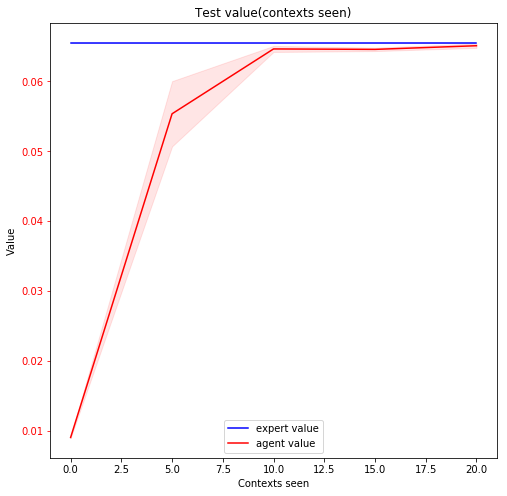

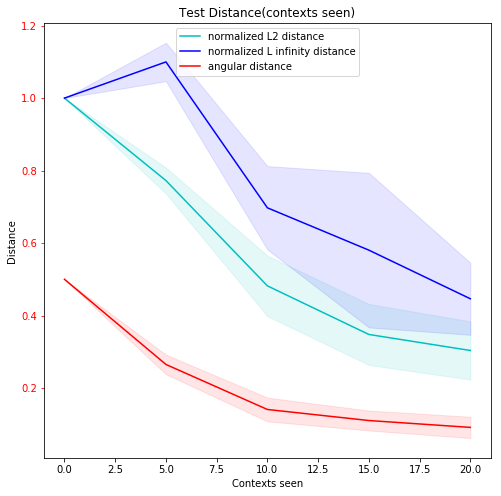

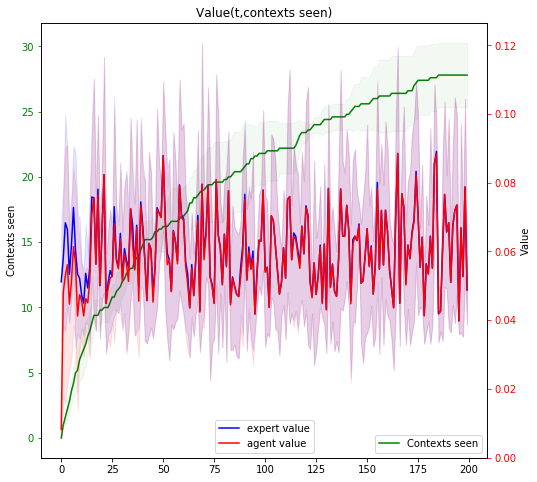

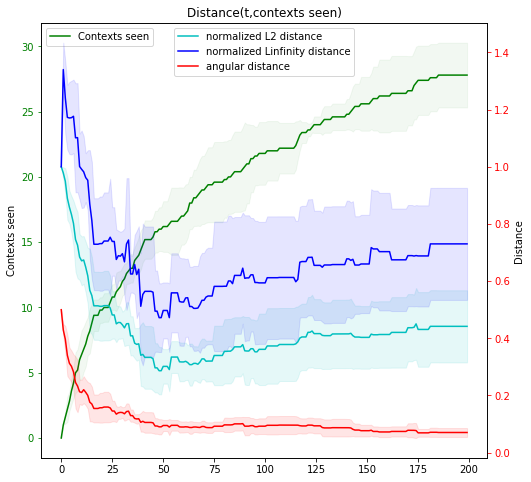

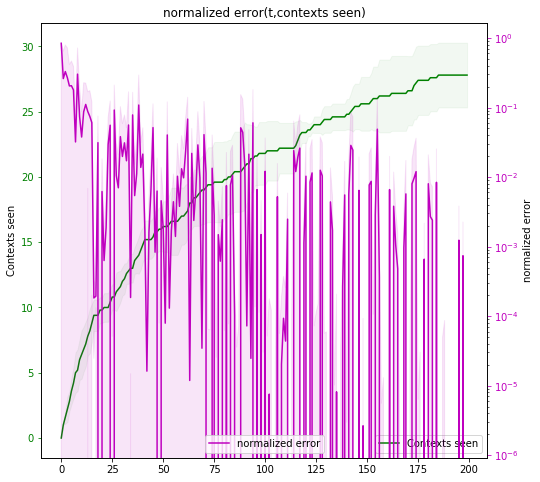

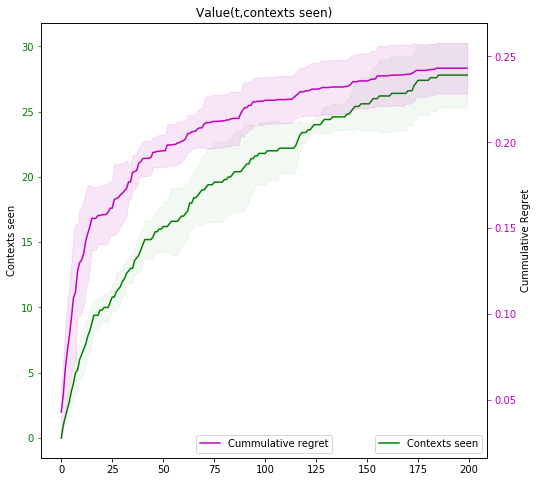

In [10]:
make_graphs()